# Lake Geometry vs Ice Phenology Analysis

**Standalone analysis notebook**

## Purpose
Analyze relationships between lake physical characteristics (size, shape, depth proxy) and ice phenology (ice-on/ice-off dates, ice-free duration).

## Data Sources
- Multi-sensor ice event detections from GCS
- Lake geometry metrics from GEE exports

## Key Questions
1. Do larger lakes freeze later and thaw earlier?
2. Does lake shape (circularity) affect ice dynamics?
3. Can we use depth proxies (volume/area ratios) to predict phenology?
4. Are there size-dependent confidence patterns in our detections?

## Analysis Plan
- Load ice event data with high/medium confidence detections
- Extract lake geometry from source data
- Correlate size with ice-on/ice-off dates
- Categorize lakes and compare phenology statistics
- Generate diagnostic visualizations

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

print("="*60)
print("LAKE GEOMETRY vs ICE PHENOLOGY ANALYSIS")
print("="*60)
print("\nNotebook Purpose:")
print("- Analyze size/shape effects on ice phenology")
print("- Identify patterns across lake categories")
print("- Validate detection quality by lake type")
print("="*60)

LAKE GEOMETRY vs ICE PHENOLOGY ANALYSIS

Notebook Purpose:
- Analyze size/shape effects on ice phenology
- Identify patterns across lake categories
- Validate detection quality by lake type


## 1. Load Data from local storage

In [71]:
# Load the files that were saved locally in the previous notebook
ice_events = pd.read_csv('alaska_lakes_ice_events_multisensor_2024.csv')
print(f"✓ Loaded {len(ice_events)} ice event records")

timeseries = pd.read_csv('alaska_lakes_timeseries_multisensor_2024.csv')
print(f"✓ Loaded {len(timeseries)} timeseries observations")

lake_geom = pd.read_csv('alaska_lake_geometries.csv')
print(f"✓ Loaded {len(lake_geom)} lake geometry records")

print("\n" + "="*60)
print(f"Ice events columns: {list(ice_events.columns)}")
print(f"\nTimeseries columns: {list(timeseries.columns)[:10]}...")
print(f"\nLake geometry columns: {list(lake_geom.columns)}")

✓ Loaded 541 ice event records
✓ Loaded 50834 timeseries observations
✓ Loaded 541 lake geometry records

Ice events columns: ['lake_id', 'ice_off_date', 'ice_on_date', 'ice_off_doy', 'ice_on_doy', 'ice_free_days', 'ice_off_confidence', 'ice_on_confidence', 'ice_off_source', 'ice_on_source', 'centroid_lat', 'centroid_lon', 'lake_area_m2']

Timeseries columns: ['lake_id', 'date', 'lake_area_m2', 'centroid_lon', 'centroid_lat', 'temp_c', 's1_ice_pred', 's1_ice_prob', 'has_s1', 's2_ice_fraction']...

Lake geometry columns: ['centroid_lat', 'centroid_lon', 'circularity', 'convexity', 'fractal_dim', 'lake_id', 'lake_area_m2', 'lake_perim_m']


## 2. Extract Lake Geometry Metrics

In [72]:
print("\n" + "="*60)
print("EXTRACTING GEOMETRY METRICS")
print("="*60)

# The timeseries is df_unified which has lake_id (not system:index)
# and lake_area_m2 (not lake_area_m2_3338)

# Get unique lake geometries from timeseries
lakes_geom = timeseries.groupby('lake_id').first().reset_index()

# Extract relevant geometry columns that exist
geom_cols = ['lake_id', 'lake_area_m2', 'centroid_lon', 'centroid_lat']

# Check which columns exist
available_cols = [col for col in geom_cols if col in lakes_geom.columns]
print(f"\nAvailable geometry columns: {available_cols}")

lakes_geom = lakes_geom[available_cols].copy()

# Calculate derived metrics
if 'lake_area_m2' in lakes_geom.columns:
    lakes_geom['lake_area_km2'] = lakes_geom['lake_area_m2'] / 1e6
    print(f"✓ Calculated area in km²")

print(f"\n✓ Geometry data for {len(lakes_geom)} lakes")
print(lakes_geom.describe())


EXTRACTING GEOMETRY METRICS

Available geometry columns: ['lake_id', 'lake_area_m2', 'centroid_lon', 'centroid_lat']
✓ Calculated area in km²

✓ Geometry data for 541 lakes
             lake_id   lake_area_m2  centroid_lon  centroid_lat  lake_area_km2
count     541.000000     541.000000    541.000000    541.000000     541.000000
mean   591251.203327   53667.608626   -149.746637     70.265104       0.053668
std     60296.833059  142225.648900      1.062813      0.121919       0.142226
min    495091.000000    1159.788712   -151.943036     70.009434       0.001160
25%    512160.000000    1398.582997   -150.626048     70.183119       0.001399
50%    629494.000000    5991.160739   -149.507083     70.270991       0.005991
75%    635187.000000   25792.127252   -148.897883     70.354844       0.025792
max    744935.000000  775200.605050   -147.925412     70.516575       0.775201


## 3. Merge Ice Events with Geometry

In [73]:
# Merge ice events with geometry
ice_events_with_geom = ice_events.merge(
    lakes_geom, 
    on='lake_id',  # Both have lake_id column
    how='left'
)

print(f"Merged dataset: {len(ice_events_with_geom)} records")
print(f"Records with geometry: {ice_events_with_geom['lake_area_km2'].notna().sum()}")

# Filter to valid events with geometry
valid_events = ice_events_with_geom[
    ice_events_with_geom['ice_off_date'].notna() & 
    ice_events_with_geom['ice_on_date'].notna() &
    ice_events_with_geom['lake_area_km2'].notna()
].copy()

print(f"\nValid events for analysis: {len(valid_events)}")

# Check what the actual confidence column is called
if 'confidence' in valid_events.columns:
    print(f"High confidence: {(valid_events['confidence'] == 'high').sum()}")
    print(f"Medium confidence: {(valid_events['confidence'] == 'medium').sum()}")
elif 'ice_off_confidence' in valid_events.columns:
    # Confidence is stored separately for ice-off and ice-on
    print(f"Ice-off high confidence: {(valid_events['ice_off_confidence'] == 'HIGH').sum()}")
    print(f"Ice-off medium confidence: {(valid_events['ice_off_confidence'] == 'MEDIUM').sum()}")
    print(f"Ice-on high confidence: {(valid_events['ice_on_confidence'] == 'HIGH').sum()}")
    print(f"Ice-on medium confidence: {(valid_events['ice_on_confidence'] == 'MEDIUM').sum()}")

Merged dataset: 541 records
Records with geometry: 541

Valid events for analysis: 541
Ice-off high confidence: 314
Ice-off medium confidence: 190
Ice-on high confidence: 518
Ice-on medium confidence: 11


## 4. Size vs Phenology Analysis

Ice phenology statistics:
Ice-off DOY: 153.5 ± 7.2
Ice-on DOY: 277.1 ± 3.6
Ice-free days: 123.6 ± 8.3


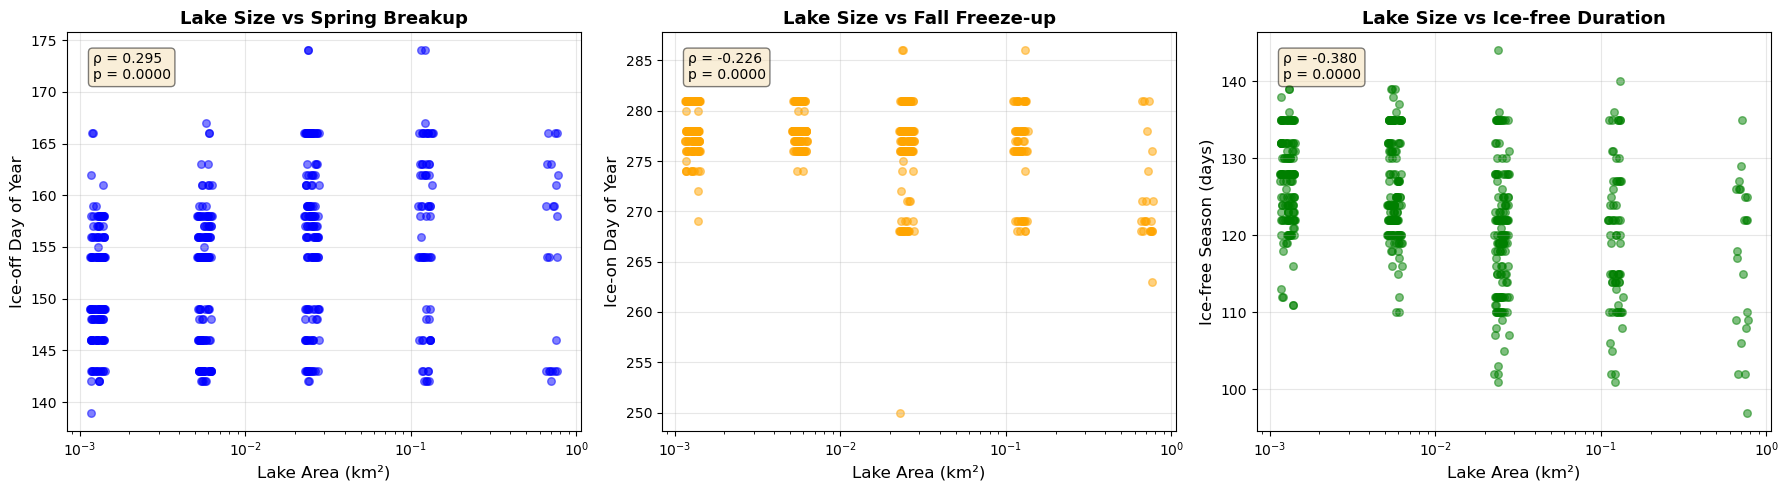


✓ Saved: lake_size_vs_ice_phenology.png

Key findings:
  Ice-off vs area: ρ=0.295 (p=0.0000)
  Ice-on vs area: ρ=-0.226 (p=0.0000)
  Ice-free days vs area: ρ=-0.380 (p=0.0000)


In [83]:
# Convert date strings to day of year for analysis
def date_to_doy(date_str):
    """Convert YYYY-MM-DD to day of year"""
    if pd.isna(date_str):
        return np.nan
    dt = pd.to_datetime(date_str)
    return dt.timetuple().tm_yday

valid_events['ice_off_doy'] = valid_events['ice_off_date'].apply(date_to_doy)
valid_events['ice_on_doy'] = valid_events['ice_on_date'].apply(date_to_doy)

print("Ice phenology statistics:")
print(f"Ice-off DOY: {valid_events['ice_off_doy'].mean():.1f} ± {valid_events['ice_off_doy'].std():.1f}")
print(f"Ice-on DOY: {valid_events['ice_on_doy'].mean():.1f} ± {valid_events['ice_on_doy'].std():.1f}")
print(f"Ice-free days: {valid_events['ice_free_days'].mean():.1f} ± {valid_events['ice_free_days'].std():.1f}")

# Analyze relationship between lake size and ice phenology
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Lake area vs Ice-off date
ax = axes[0]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_off_doy'], 
           alpha=0.5, s=30, color='blue')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-off Day of Year', fontsize=12)
ax.set_title('Lake Size vs Spring Breakup', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

# Add correlation
corr_off, p_off = spearmanr(valid_events['lake_area_km2'], valid_events['ice_off_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_off:.3f}\np = {p_off:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Lake area vs Ice-on date
ax = axes[1]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_on_doy'], 
           alpha=0.5, s=30, color='orange')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-on Day of Year', fontsize=12)
ax.set_title('Lake Size vs Fall Freeze-up', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

corr_on, p_on = spearmanr(valid_events['lake_area_km2'], valid_events['ice_on_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_on:.3f}\np = {p_on:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Lake area vs Ice-free season
ax = axes[2]
ax.scatter(valid_events['lake_area_km2'], valid_events['ice_free_days'], 
           alpha=0.5, s=30, color='green')
ax.set_xlabel('Lake Area (km²)', fontsize=12)
ax.set_ylabel('Ice-free Season (days)', fontsize=12)
ax.set_title('Lake Size vs Ice-free Duration', fontsize=13, fontweight='bold')
ax.set_xscale('log')
ax.grid(alpha=0.3)

corr_season, p_season = spearmanr(valid_events['lake_area_km2'], valid_events['ice_free_days'])
ax.text(0.05, 0.95, f'ρ = {corr_season:.3f}\np = {p_season:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('lake_size_vs_ice_phenology.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: lake_size_vs_ice_phenology.png")
print("\nKey findings:")
print(f"  Ice-off vs area: ρ={corr_off:.3f} (p={p_off:.4f})")
print(f"  Ice-on vs area: ρ={corr_on:.3f} (p={p_on:.4f})")
print(f"  Ice-free days vs area: ρ={corr_season:.3f} (p={p_season:.4f})")

✓ Saved: lake_size_vs_phenology.png


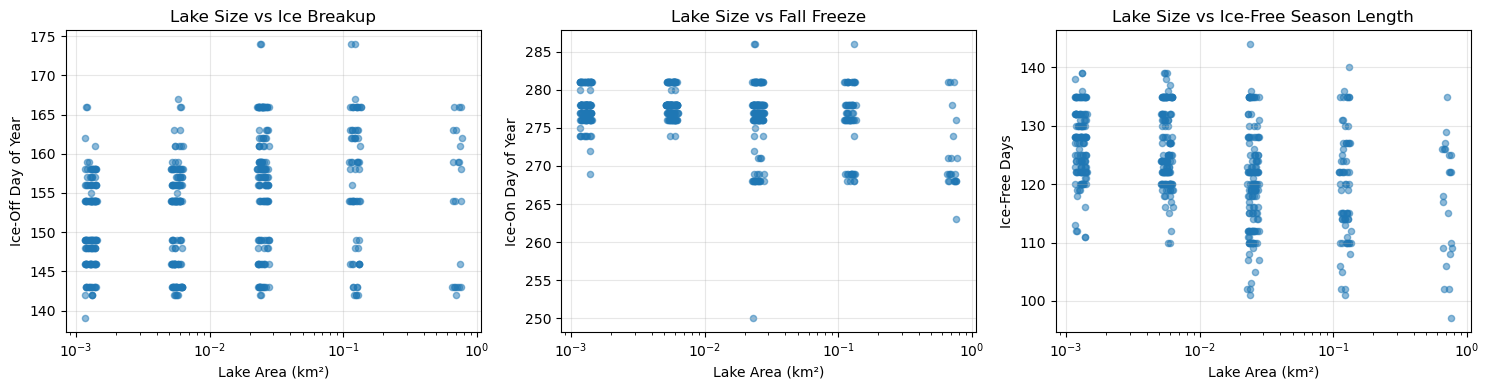


Correlations with lake size:
Ice-off DOY: r = 0.078
Ice-on DOY: r = -0.369
Ice-free days: r = -0.229


In [75]:
# Scatter plots: lake size vs phenology
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Ice-off vs size
axes[0].scatter(valid_events['lake_area_km2'], valid_events['ice_off_doy'], 
                alpha=0.5, s=20)
axes[0].set_xlabel('Lake Area (km²)')
axes[0].set_ylabel('Ice-Off Day of Year')
axes[0].set_title('Lake Size vs Ice Breakup')
axes[0].set_xscale('log')
axes[0].grid(alpha=0.3)

# Ice-on vs size
axes[1].scatter(valid_events['lake_area_km2'], valid_events['ice_on_doy'], 
                alpha=0.5, s=20)
axes[1].set_xlabel('Lake Area (km²)')
axes[1].set_ylabel('Ice-On Day of Year')
axes[1].set_title('Lake Size vs Fall Freeze')
axes[1].set_xscale('log')
axes[1].grid(alpha=0.3)

# Ice-free duration vs size
axes[2].scatter(valid_events['lake_area_km2'], valid_events['ice_free_days'], 
                alpha=0.5, s=20)
axes[2].set_xlabel('Lake Area (km²)')
axes[2].set_ylabel('Ice-Free Days')
axes[2].set_title('Lake Size vs Ice-Free Season Length')
axes[2].set_xscale('log')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('lake_size_vs_phenology.png', dpi=150, bbox_inches='tight')
print("✓ Saved: lake_size_vs_phenology.png")
plt.show()

# Correlation statistics
print("\nCorrelations with lake size:")
print(f"Ice-off DOY: r = {valid_events['lake_area_km2'].corr(valid_events['ice_off_doy']):.3f}")
print(f"Ice-on DOY: r = {valid_events['lake_area_km2'].corr(valid_events['ice_on_doy']):.3f}")
print(f"Ice-free days: r = {valid_events['lake_area_km2'].corr(valid_events['ice_free_days']):.3f}")

## 5. Lake Size Categories


Phenology by Lake Size Class:
                       lake_id ice_off_doy      ice_on_doy      ice_free_days  \
                         count        mean  std       mean  std          mean   
size_class                                                                      
Very Small (<0.05 km²)     450       153.0  6.8      277.5  3.1         124.5   
Small (0.05-0.2 km²)        69       156.5  8.5      276.0  4.4         119.5   
Medium (0.2-1 km²)          22       154.1  9.1      271.3  5.0         117.2   
Large (>1 km²)               0         NaN  NaN        NaN  NaN           NaN   

                              
                         std  
size_class                    
Very Small (<0.05 km²)   7.6  
Small (0.05-0.2 km²)     9.3  
Medium (0.2-1 km²)      10.3  
Large (>1 km²)           NaN  


/var/tmp/ipykernel_44127/1051817548.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_summary = valid_events.groupby('size_class').agg({


✓ Saved: phenology_by_size_class.png


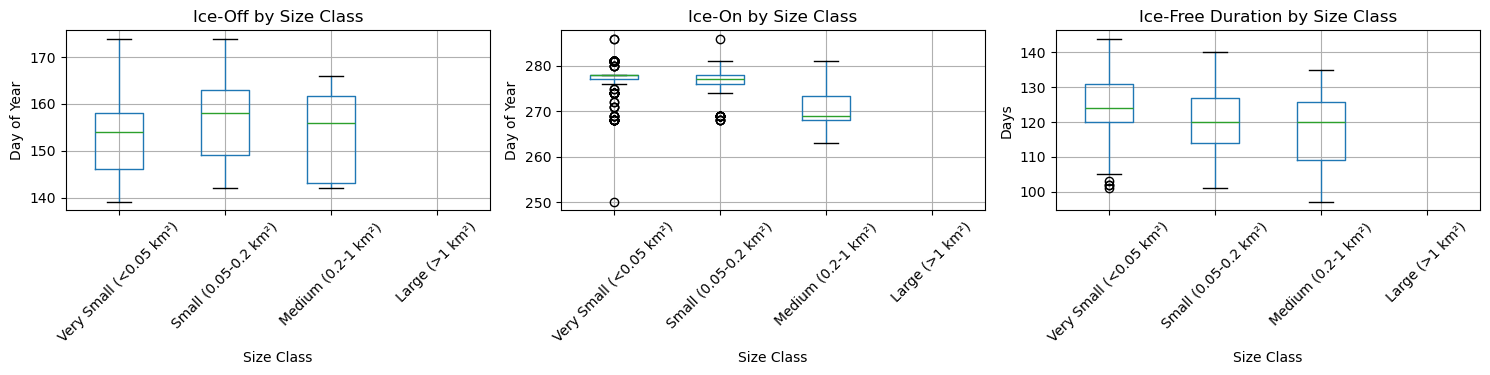

In [76]:
# Categorize lakes by size
valid_events['size_class'] = pd.cut(
    valid_events['lake_area_km2'], 
    bins=[0, 0.05, 0.2, 1.0, 100],
    labels=['Very Small (<0.05 km²)', 'Small (0.05-0.2 km²)', 
            'Medium (0.2-1 km²)', 'Large (>1 km²)']
)

# Summary by size class
size_summary = valid_events.groupby('size_class').agg({
    'lake_id': 'count',
    'ice_off_doy': ['mean', 'std'],
    'ice_on_doy': ['mean', 'std'],
    'ice_free_days': ['mean', 'std']
}).round(1)

print("\nPhenology by Lake Size Class:")
print(size_summary)

# Box plots by size class
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

valid_events.boxplot(column='ice_off_doy', by='size_class', ax=axes[0])
axes[0].set_title('Ice-Off by Size Class')
axes[0].set_xlabel('Size Class')
axes[0].set_ylabel('Day of Year')
axes[0].tick_params(axis='x', rotation=45)

valid_events.boxplot(column='ice_on_doy', by='size_class', ax=axes[1])
axes[1].set_title('Ice-On by Size Class')
axes[1].set_xlabel('Size Class')
axes[1].set_ylabel('Day of Year')
axes[1].tick_params(axis='x', rotation=45)

valid_events.boxplot(column='ice_free_days', by='size_class', ax=axes[2])
axes[2].set_title('Ice-Free Duration by Size Class')
axes[2].set_xlabel('Size Class')
axes[2].set_ylabel('Days')
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig('phenology_by_size_class.png', dpi=150, bbox_inches='tight')
print("✓ Saved: phenology_by_size_class.png")
plt.show()

## 6. Shape Effects

✓ Saved: shape_vs_phenology.png


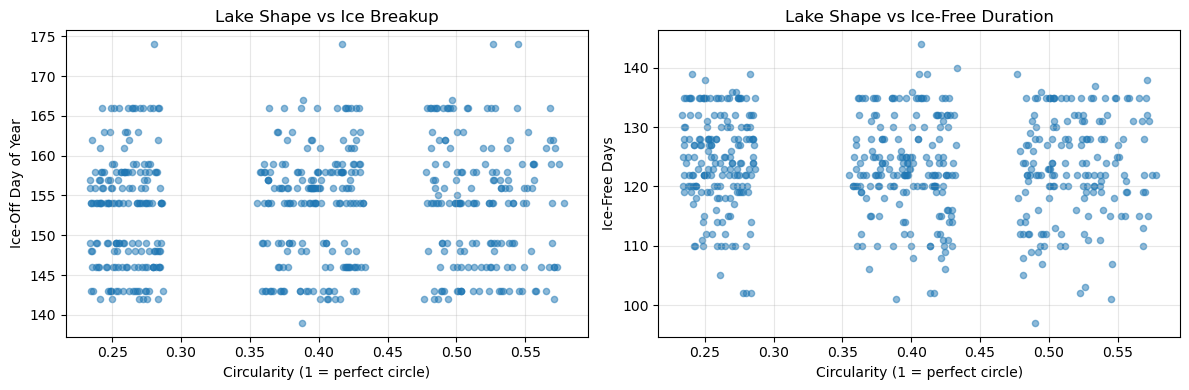


Correlations with circularity:
Ice-off DOY: r = 0.052
Ice-free days: r = -0.059


In [78]:
# Merge circularity from lake_geom into valid_events
valid_with_shape = valid_events.merge(
    lake_geom[['lake_id', 'circularity', 'lake_perim_m', 'fractal_dim', 'convexity']], 
    on='lake_id', 
    how='left'
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Circularity vs ice-off
axes[0].scatter(valid_with_shape['circularity'], valid_with_shape['ice_off_doy'], 
                alpha=0.5, s=20)
axes[0].set_xlabel('Circularity (1 = perfect circle)')
axes[0].set_ylabel('Ice-Off Day of Year')
axes[0].set_title('Lake Shape vs Ice Breakup')
axes[0].grid(alpha=0.3)

# Circularity vs ice-free days
axes[1].scatter(valid_with_shape['circularity'], valid_with_shape['ice_free_days'], 
                alpha=0.5, s=20)
axes[1].set_xlabel('Circularity (1 = perfect circle)')
axes[1].set_ylabel('Ice-Free Days')
axes[1].set_title('Lake Shape vs Ice-Free Duration')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('shape_vs_phenology.png', dpi=150, bbox_inches='tight')
print("✓ Saved: shape_vs_phenology.png")
plt.show()

print("\nCorrelations with circularity:")
print(f"Ice-off DOY: r = {valid_with_shape['circularity'].corr(valid_with_shape['ice_off_doy']):.3f}")
print(f"Ice-free days: r = {valid_with_shape['circularity'].corr(valid_with_shape['ice_free_days']):.3f}")

## 7. Detection Quality by Lake Size

/var/tmp/ipykernel_44127/2609579248.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  confidence_by_size = ice_events_with_geom.groupby(



Detection Confidence by Lake Size (Ice-Off):
ice_off_confidence  HIGH  LOW  MEDIUM  NONE
lake_area_km2                              
<0.05                280   30     139     1
0.05-0.2              28    4      37     0
0.2-1                  6    2      14     0
>1                     0    0       0     0

Percentage high-confidence by size:
lake_area_km2
<0.05       62.2
0.05-0.2    40.6
0.2-1       27.3
>1           NaN
dtype: float64
✓ Saved: confidence_by_size.png


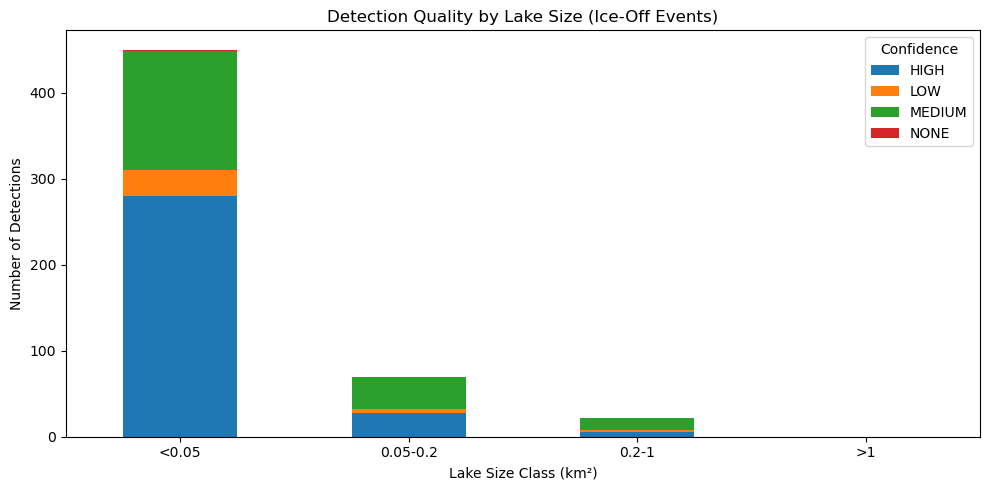

In [81]:
# How does detection confidence vary with lake size?
# Use ice_off_confidence as the primary confidence metric
confidence_by_size = ice_events_with_geom.groupby(
    pd.cut(ice_events_with_geom['lake_area_km2'], 
           bins=[0, 0.05, 0.2, 1.0, 100],
           labels=['<0.05', '0.05-0.2', '0.2-1', '>1'])
)['ice_off_confidence'].value_counts().unstack(fill_value=0)

print("\nDetection Confidence by Lake Size (Ice-Off):")
print(confidence_by_size)

print("\nPercentage high-confidence by size:")
if 'HIGH' in confidence_by_size.columns:
    print((confidence_by_size['HIGH'] / confidence_by_size.sum(axis=1) * 100).round(1))

# Visualize
confidence_by_size.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.xlabel('Lake Size Class (km²)')
plt.ylabel('Number of Detections')
plt.title('Detection Quality by Lake Size (Ice-Off Events)')
plt.legend(title='Confidence')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('confidence_by_size.png', dpi=150, bbox_inches='tight')
print("✓ Saved: confidence_by_size.png")
plt.show()

## 8. Summary Statistics

In [84]:
## Part 8: Comprehensive Correlation Analysis

# Create correlation matrix for all geometry metrics vs ice phenology
from scipy.stats import spearmanr

# First merge all geometry metrics into valid_events if not already done
if 'circularity' not in valid_events.columns:
    valid_events = valid_events.merge(
        lake_geom[['lake_id', 'circularity', 'lake_perim_m', 'fractal_dim', 'convexity']], 
        on='lake_id', 
        how='left'
    )

# Define metrics to analyze
geom_metrics = ['lake_area_km2']

# Add other metrics if they exist
optional_metrics = ['circularity', 'convexity', 'fractal_dim', 'lake_perim_m']
for metric in optional_metrics:
    if metric in valid_events.columns:
        geom_metrics.append(metric)

ice_metrics = ['ice_off_doy', 'ice_on_doy', 'ice_free_days']

print("\n" + "="*60)
print("CORRELATION ANALYSIS: GEOMETRY vs ICE PHENOLOGY")
print("="*60)
print(f"\nGeometry metrics: {geom_metrics}")
print(f"Ice phenology metrics: {ice_metrics}")

# Compute correlation matrix
corr_results = []
for geom in geom_metrics:
    for ice_var in ice_metrics:
        # Remove NaN values for this pair
        valid_pairs = valid_events[[geom, ice_var]].dropna()
        
        if len(valid_pairs) > 10:  # Need at least 10 data points
            corr, pval = spearmanr(valid_pairs[geom], valid_pairs[ice_var])
            corr_results.append({
                'geometry': geom,
                'ice_variable': ice_var,
                'correlation': corr,
                'p_value': pval,
                'n': len(valid_pairs)
            })

corr_df = pd.DataFrame(corr_results)

# Format for display
print("\nSpearman Correlations (ρ):")
print("-" * 60)
pivot = corr_df.pivot(index='geometry', columns='ice_variable', values='correlation')
print(pivot.round(3))

print("\n\nP-values:")
print("-" * 60)
pivot_p = corr_df.pivot(index='geometry', columns='ice_variable', values='p_value')
print(pivot_p.round(4))

# Highlight significant correlations (p < 0.05)
print("\n\nSignificant correlations (p < 0.05):")
print("-" * 60)
sig_corr = corr_df[corr_df['p_value'] < 0.05].sort_values('correlation', key=abs, ascending=False)
if len(sig_corr) > 0:
    for _, row in sig_corr.iterrows():
        print(f"{row['geometry']:20s} → {row['ice_variable']:15s}: ρ={row['correlation']:6.3f}, p={row['p_value']:.4f} (n={row['n']})")
else:
    print("No significant correlations found")

# Export
corr_df.to_csv('geometry_ice_correlations.csv', index=False)
print("\n✓ Saved: geometry_ice_correlations.csv")


CORRELATION ANALYSIS: GEOMETRY vs ICE PHENOLOGY

Geometry metrics: ['lake_area_km2', 'circularity', 'convexity', 'fractal_dim', 'lake_perim_m']
Ice phenology metrics: ['ice_off_doy', 'ice_on_doy', 'ice_free_days']

Spearman Correlations (ρ):
------------------------------------------------------------
ice_variable   ice_free_days  ice_off_doy  ice_on_doy
geometry                                             
circularity           -0.054        0.049      -0.022
convexity             -0.229        0.183      -0.107
fractal_dim            0.203       -0.160       0.117
lake_area_km2         -0.380        0.295      -0.226
lake_perim_m          -0.350        0.268      -0.214


P-values:
------------------------------------------------------------
ice_variable   ice_free_days  ice_off_doy  ice_on_doy
geometry                                             
circularity           0.2137       0.2516      0.6151
convexity             0.0000       0.0000      0.0130
fractal_dim           0.0000 

## 9: Latitude Gradient Analysis

Centroid columns: ['centroid_lat_x', 'centroid_lon_x', 'centroid_lon_y', 'centroid_lat_y']


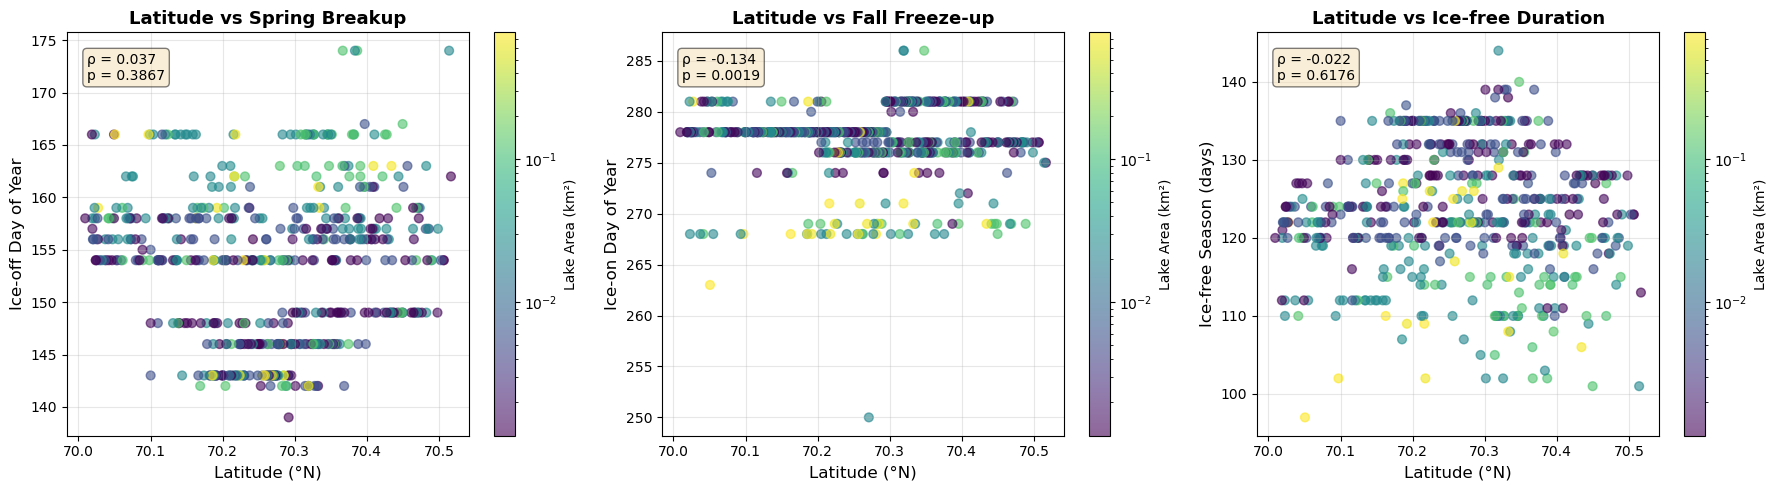

✓ Saved: latitude_vs_ice_phenology.png

Latitudinal gradients:
  Ice-off vs latitude: ρ=0.037 (p=0.3867)
  Ice-on vs latitude: ρ=-0.134 (p=0.0019)
  Ice-free days vs latitude: ρ=-0.022 (p=0.6176)


In [88]:

# Check which centroid columns exist
print("Centroid columns:", [col for col in valid_events.columns if 'centroid' in col])

# Use the correct column name (likely centroid_lat_x from the merge)
lat_col = 'centroid_lat_x' if 'centroid_lat_x' in valid_events.columns else 'centroid_lat'
lon_col = 'centroid_lon_x' if 'centroid_lon_x' in valid_events.columns else 'centroid_lon'

# Analyze latitude gradient
from scipy.stats import spearmanr

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Latitude vs Ice-off
ax = axes[0]
scatter = ax.scatter(valid_events[lat_col], valid_events['ice_off_doy'],
                     c=valid_events['lake_area_km2'], cmap='viridis', 
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-off Day of Year', fontsize=12)
ax.set_title('Latitude vs Spring Breakup', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_off, p_lat_off = spearmanr(valid_events[lat_col], valid_events['ice_off_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_off:.3f}\np = {p_lat_off:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Latitude vs Ice-on
ax = axes[1]
scatter = ax.scatter(valid_events[lat_col], valid_events['ice_on_doy'],
                     c=valid_events['lake_area_km2'], cmap='viridis',
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-on Day of Year', fontsize=12)
ax.set_title('Latitude vs Fall Freeze-up', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_on, p_lat_on = spearmanr(valid_events[lat_col], valid_events['ice_on_doy'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_on:.3f}\np = {p_lat_on:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Latitude vs Ice-free season
ax = axes[2]
scatter = ax.scatter(valid_events[lat_col], valid_events['ice_free_days'],
                     c=valid_events['lake_area_km2'], cmap='viridis',
                     alpha=0.6, s=40, norm=plt.matplotlib.colors.LogNorm())
ax.set_xlabel('Latitude (°N)', fontsize=12)
ax.set_ylabel('Ice-free Season (days)', fontsize=12)
ax.set_title('Latitude vs Ice-free Duration', fontsize=13, fontweight='bold')
ax.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Lake Area (km²)', fontsize=10)

corr_lat_season, p_lat_season = spearmanr(valid_events[lat_col], valid_events['ice_free_days'])
ax.text(0.05, 0.95, f'ρ = {corr_lat_season:.3f}\np = {p_lat_season:.4f}', 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('latitude_vs_ice_phenology.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Saved: latitude_vs_ice_phenology.png")
print("\nLatitudinal gradients:")
print(f"  Ice-off vs latitude: ρ={corr_lat_off:.3f} (p={p_lat_off:.4f})")
print(f"  Ice-on vs latitude: ρ={corr_lat_on:.3f} (p={p_lat_on:.4f})")
print(f"  Ice-free days vs latitude: ρ={corr_lat_season:.3f} (p={p_lat_season:.4f})")

## 10. Export Results

In [89]:
# Save enhanced dataset with geometry
output_file = 'lake_geometry_phenology_analysis.csv'
valid_events.to_csv(output_file, index=False)
print(f"✓ Saved analysis results to {output_file}")

# Save summary statistics
with open('geometry_phenology_summary.txt', 'w') as f:
    f.write("LAKE GEOMETRY - ICE PHENOLOGY ANALYSIS SUMMARY\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M')}\n")
    f.write(f"Total lakes: {len(valid_events)}\n\n")
    
    f.write("PHENOLOGY BY SIZE CLASS\n")
    f.write(size_summary.to_string())
    f.write("\n\n")
    
    f.write("CORRELATIONS (Pearson)\n")
    f.write(f"Size vs ice-off: {valid_events['lake_area_km2'].corr(valid_events['ice_off_doy']):.3f}\n")
    f.write(f"Size vs ice-on: {valid_events['lake_area_km2'].corr(valid_events['ice_on_doy']):.3f}\n")
    f.write(f"Size vs ice-free days: {valid_events['lake_area_km2'].corr(valid_events['ice_free_days']):.3f}\n")
    f.write("\n")
    
    f.write("COMPREHENSIVE CORRELATION MATRIX (Spearman ρ)\n")
    f.write("-" * 60 + "\n")
    f.write(pivot.to_string())
    f.write("\n\n")
    
    f.write("SIGNIFICANT CORRELATIONS (p < 0.05)\n")
    f.write("-" * 60 + "\n")
    if len(sig_corr) > 0:
        for _, row in sig_corr.iterrows():
            f.write(f"{row['geometry']:20s} → {row['ice_variable']:15s}: ρ={row['correlation']:6.3f}, p={row['p_value']:.4f}\n")
    else:
        f.write("No significant correlations found\n")

print("✓ Saved summary to geometry_phenology_summary.txt")
print("\nAnalysis complete!")

✓ Saved analysis results to lake_geometry_phenology_analysis.csv
✓ Saved summary to geometry_phenology_summary.txt

Analysis complete!
